In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

### Data

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [56]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

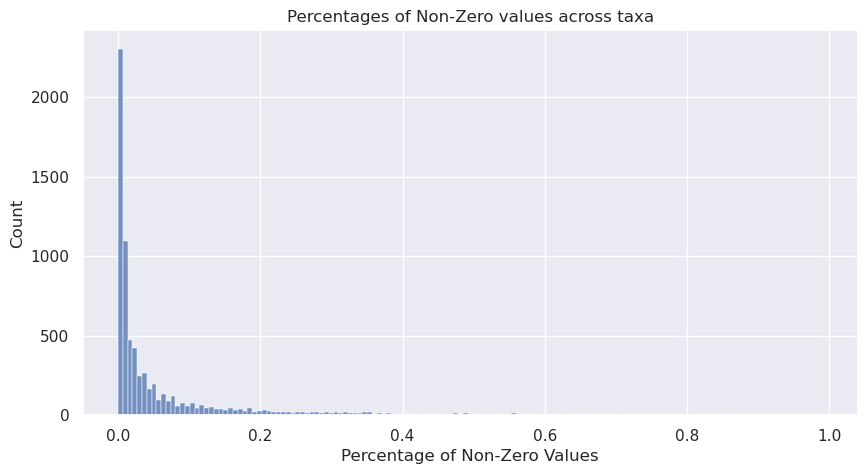

In [57]:
population_rates = calculate_population_rates(df)

plt.figure(figsize=(10,5))
sns.histplot(population_rates)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

### Preprocessing

In [58]:
min_population_rate = 0.3
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, min_population_rate)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [59]:
new_population_rates = calculate_population_rates(df)
new_population_rates.describe()

count   502.000000
mean      0.718602
std       0.139937
min       0.439306
25%       0.604046
50%       0.709056
75%       0.827553
max       1.000000
dtype: float64

### Features and tergets


In [60]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E014086' 'E012854' 'E003188']


In [61]:
df

,189592,4343580,194104,362389,1142029,199301,659361,364179,313387,3439402,...,196664,364563,583117,365385,580008,267718,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.130435,0.000000,0.000000,0.011834,0.000000,0.000000,0.000160,0.000000,0.288889,...,0.059699,0.000000,0.010154,0.000537,0.000000,0.000000,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.043478,0.000000,0.000000,0.011834,0.000000,0.000000,0.000160,0.000000,0.200000,...,0.054162,0.000000,0.010779,0.000627,0.000000,0.000000,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000000,0.000000,0.000000,0.005917,0.000000,0.000000,0.000180,0.000000,0.200000,...,0.060045,0.000000,0.009685,0.000537,0.000000,0.000000,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.000000,0.000000,0.000000,0.062500,0.029586,0.000000,0.065636,0.000160,0.180000,0.088889,...,0.035127,0.000000,0.006092,0.000448,0.000000,0.000000,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.000000,0.000000,0.000000,0.062500,0.094675,0.000000,0.065636,0.000220,0.180000,0.177778,...,0.061602,0.000000,0.037334,0.000269,0.000000,0.000000,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.003226,0.304348,0.258065,0.031250,0.000000,0.268222,0.060355,0.080890,0.040000,0.288889,...,0.127531,0.019231,0.423113,0.000090,0.169998,0.242718,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.003226,0.260870,0.333333,0.031250,0.000000,0.355685,0.060355,0.120524,0.060000,0.622222,...,0.345042,0.076923,0.622876,0.000090,0.162571,0.194175,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.003226,0.304348,0.354839,0.031250,0.000000,0.338192,0.051679,0.141802,0.040000,1.000000,...,0.537809,0.096154,0.756436,0.000090,0.179809,0.106796,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.003226,0.173913,0.387097,0.000000,0.000000,0.317784,0.021124,0.127490,0.060000,0.977778,...,0.631597,0.105769,0.749125,0.000000,0.155419,0.087379,0.610837,E014086,0.948127,0.948127


In [62]:
print(len(train_feats), len(train_targets))

261 261


### The Model

In [63]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=1)

n_ins = len(train_feats[0][0])
n_outs = len(df.columns) - len(metadata_cols) + 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_ins)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_outs, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              6332416   
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 499)               1022451   
                                                                 
Total params: 9454067 (36.06 MB)
Trainable params: 9454067 (36.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [64]:
train_feats = np.asarray(train_feats).astype("float32")
train_targets = np.asarray(train_targets).astype("float32")

model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=100)

Epoch 1/100
8/8 [==============================] - 2s 40ms/step - loss: 32.7503 - mae: 0.0953 - mape: 1697159.6250 - val_loss: 29.6245 - val_mae: 0.0920 - val_mape: 705017.4375
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 27.5442 - mae: 0.0875 - mape: 580349.3750 - val_loss: 25.4337 - val_mae: 0.0885 - val_mape: 667044.8750
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 23.5139 - mae: 0.0835 - mape: 456946.6562 - val_loss: 21.8313 - val_mae: 0.0847 - val_mape: 610687.0000
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 20.2422 - mae: 0.0798 - mape: 462023.1250 - val_loss: 19.0489 - val_mae: 0.0813 - val_mape: 691183.6250
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 17.6573 - mae: 0.0763 - mape: 435143.8438 - val_loss: 16.9838 - val_mae: 0.0792 - val_mape: 669810.3750
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 15.7924 - mae: 0.0740 - mape: 436786.6250 - val

In [65]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols_true = df.columns[df.columns != "subject_id"]
    cols_pred = df.columns[~df.columns.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]
    
    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols_true
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols_pred
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [66]:
target_subject_idx = 0

test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

1/1 [==============================] - 0s 91ms/step


In [67]:
test_subject_targets_df

,189592,4343580,194104,362389,1142029,199301,659361,364179,313387,3439402,...,323862,196664,364563,583117,365385,580008,267718,354850,sampling_day,ind_time
E014086.13.5,0.058065,0.173913,0.139785,0.000000,0.000000,0.725948,0.013580,0.247113,0.080000,0.022222,...,0.033333,0.037896,0.000000,0.061985,0.000000,0.000000,0.135922,0.290640,0.345821,0.025937
E014086.14.6,0.045161,0.391304,0.268817,0.062500,0.000000,0.935860,0.054319,0.755530,0.200000,0.155556,...,0.133333,0.120436,0.000000,0.144433,0.000090,0.000092,0.349515,0.290640,0.377522,0.031700
E014086.15.6,0.009677,0.260870,0.161290,0.062500,0.000000,0.370262,0.042248,0.656925,0.140000,0.177778,...,0.100000,0.134106,0.000000,0.153212,0.000090,0.000092,0.349515,0.108374,0.406340,0.028818
E014086.16.6,0.006452,0.434783,0.182796,0.125000,0.000000,0.434402,0.042248,0.795924,0.120000,0.155556,...,0.133333,0.195189,0.000000,0.138247,0.000090,0.000183,0.310680,0.073892,0.435159,0.028818
E014086.17.6,0.077419,0.391304,0.129032,0.093750,0.011834,0.145773,0.000000,0.272915,0.000000,0.088889,...,0.033333,0.117840,0.028846,0.056111,0.001612,0.282413,0.097087,0.059113,0.463977,0.028818
E014086.18.4,0.077419,0.434783,0.150538,0.156250,0.011834,0.177843,0.000377,0.308345,0.000000,0.088889,...,0.033333,0.121128,0.028846,0.065577,0.001612,0.282413,0.155340,0.251232,0.487032,0.023055
E014086.19.4,0.077419,0.260870,0.118280,0.093750,0.011834,0.116618,0.000377,0.100947,0.000000,0.111111,...,0.033333,0.033224,0.028846,0.033992,0.001701,0.282322,0.077670,0.482759,0.515850,0.028818
E014086.20.4,0.006452,0.086957,0.032258,0.062500,0.000000,0.139942,0.000377,0.150770,0.040000,0.044444,...,0.033333,0.045164,0.000000,0.079105,0.000090,0.000000,0.077670,0.655172,0.544669,0.028818
E014086.21.4,0.006452,0.043478,0.064516,0.000000,0.000000,0.157434,0.000377,0.096563,0.040000,0.133333,...,0.033333,0.098460,0.000000,0.177424,0.000090,0.000000,0.135922,0.546798,0.573487,0.028818
E014086.22.5,0.003226,0.000000,0.139785,0.000000,0.000000,0.137026,0.000377,0.073643,0.040000,0.222222,...,0.066667,0.092750,0.000000,0.208729,0.000000,0.000000,0.135922,0.463054,0.605187,0.031700


In [68]:
test_subject_y_pred_df

,189592,4343580,194104,362389,1142029,199301,659361,364179,313387,3439402,...,3799784,4334711,323862,196664,364563,583117,365385,580008,267718,354850
E014086.13.5,0.045972,0.115974,0.084552,0.128679,0.000000,0.114948,0.031364,0.000000,0.066657,0.121298,...,0.000000,0.088145,0.027251,0.065381,0.051559,0.152175,0.000000,0.000000,0.000000,0.325001
E014086.14.6,0.046369,0.119328,0.090929,0.116188,0.000000,0.106234,0.029803,0.000000,0.059804,0.135743,...,0.000000,0.093932,0.028207,0.083816,0.054632,0.165746,0.000000,0.000000,0.025585,0.308937
E014086.15.6,0.074461,0.129301,0.124346,0.108116,0.000000,0.143056,0.020001,0.000000,0.059489,0.170367,...,0.000000,0.104173,0.055869,0.101928,0.057784,0.186954,0.000000,0.000000,0.072011,0.272351
E014086.16.6,0.066454,0.115738,0.153804,0.076998,0.000000,0.077079,0.024626,0.000000,0.050849,0.156720,...,0.000000,0.085715,0.048516,0.096536,0.043713,0.162808,0.000000,0.000000,0.084638,0.181375
E014086.17.6,0.053383,0.105806,0.177841,0.033642,0.000000,0.054182,0.023346,0.000000,0.034613,0.126812,...,0.000000,0.065088,0.024139,0.085272,0.026980,0.135807,0.000000,0.000000,0.075269,0.144832
E014086.18.4,0.047764,0.106446,0.180823,0.017264,0.000000,0.035606,0.024806,0.000000,0.026533,0.107296,...,0.000000,0.056967,0.006779,0.077520,0.025091,0.118824,0.000000,0.000000,0.057617,0.145686
E014086.19.4,0.047413,0.104873,0.179247,0.025857,0.000000,0.037539,0.022609,0.000000,0.022176,0.105939,...,0.000000,0.057505,0.003865,0.078503,0.033794,0.114447,0.000000,0.000000,0.059084,0.150328
E014086.20.4,0.047929,0.096458,0.178303,0.032792,0.000000,0.043574,0.023865,0.000000,0.026619,0.109241,...,0.000000,0.059121,0.004690,0.073732,0.038551,0.113180,0.000000,0.000000,0.056458,0.162985
E014086.21.4,0.045911,0.082957,0.173328,0.037213,0.000000,0.051788,0.018970,0.000000,0.020055,0.109890,...,0.000000,0.058240,0.007632,0.075846,0.034071,0.119836,0.000000,0.000000,0.056907,0.180340
E014086.22.5,0.040813,0.075168,0.157630,0.045088,0.000000,0.052024,0.012611,0.000000,0.013460,0.110638,...,0.000000,0.062336,0.005714,0.079290,0.029640,0.128376,0.000000,0.000000,0.053957,0.191067


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [69]:
non_predicted_taxa = [col for col in test_subject_y_pred_df.columns if all(test_subject_y_pred_df[col] == 0.0)]
n_non_predicted_taxa = len(non_predicted_taxa)

print(f"Total taxa not predicted: {len(non_predicted_taxa)}, {(n_non_predicted_taxa/len(test_subject_targets_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 85, 16.966067864271455% of all taxa


The next section allows to examine individual true and predicted sequences

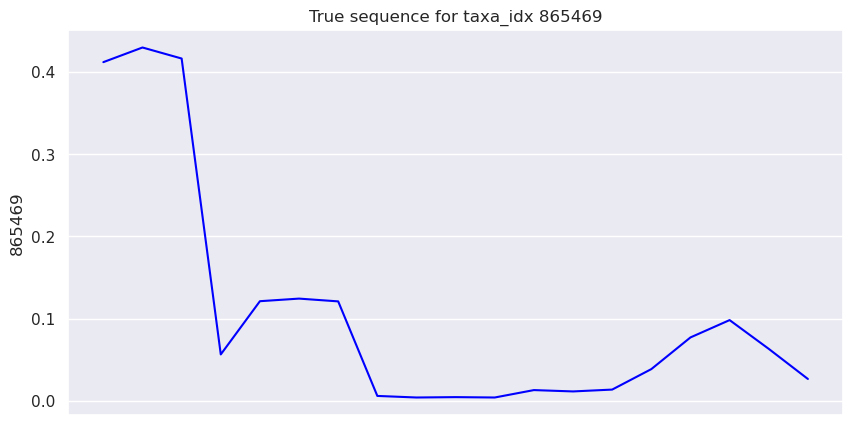

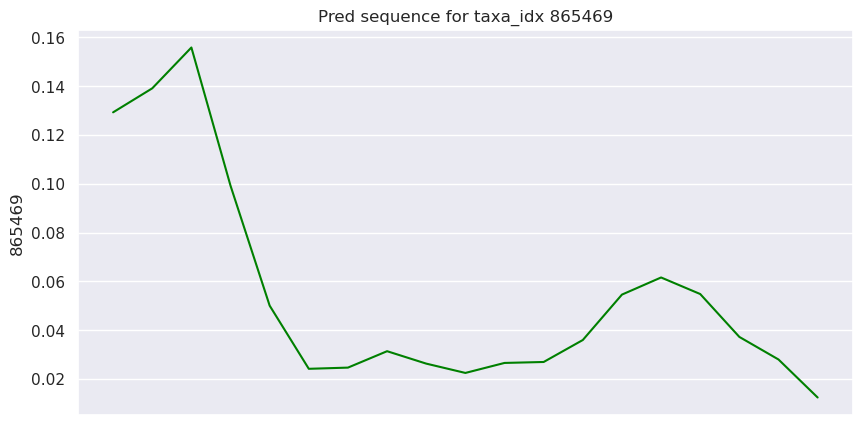

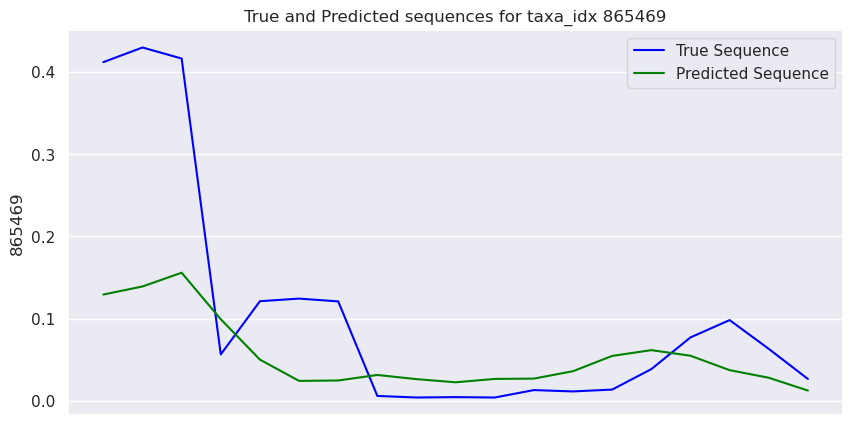

In [70]:
target_taxa = 865469
target_subject_idx = 0

target_subject = test_subjects[target_subject_idx]

true_sequence = test_subject_targets_df[target_taxa].reset_index(drop=True)
pred_sequence = test_subject_y_pred_df[target_taxa].reset_index(drop=True)

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences and test subjects. Errors are calculated individually by test subjects and then averaged

In [71]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

1/1 [==============================] - 0s 19ms/step


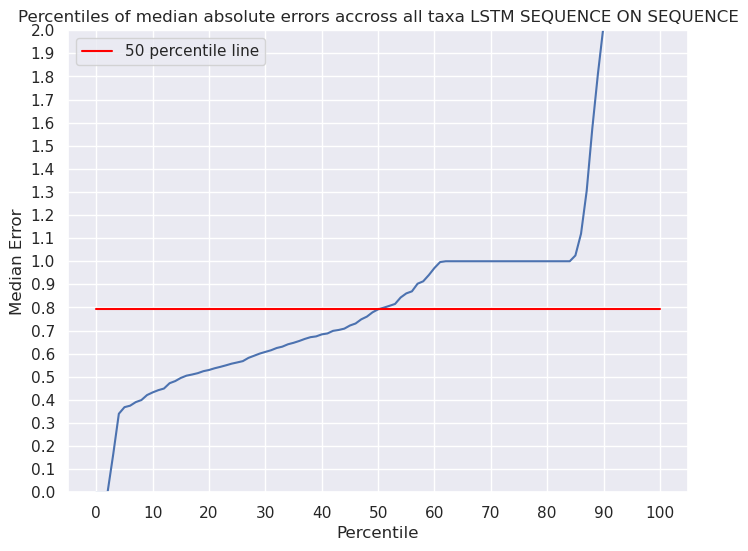

In [72]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [73]:
only_predicted_taxa = test_subject_y_pred_df.columns[~(test_subject_y_pred_df.columns.isin(non_predicted_taxa))]
only_predicted_errors = errors_df[only_predicted_taxa]
only_predicted_errors.describe()

,189592,4343580,194104,362389,199301,659361,313387,3439402,336614,509709,...,4305793,193233,184420,4334711,323862,196664,364563,583117,267718,354850
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
unique,57.000000,58.000000,54.000000,57.000000,53.000000,58.000000,57.000000,58.000000,58.000000,50.000000,...,52.000000,58.000000,57.000000,58.000000,57.000000,58.000000,58.000000,58.000000,56.000000,58.000000
top,0.000000,0.333151,0.000000,0.000000,0.000000,1.309639,1.000000,4.458390,0.807343,0.000000,...,0.000000,3.038833,1.000000,0.394481,0.000000,0.725277,515591502.189636,1.455057,0.000000,0.118224
freq,2.000000,1.000000,5.000000,2.000000,5.000000,1.000000,2.000000,1.000000,1.000000,9.000000,...,7.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000


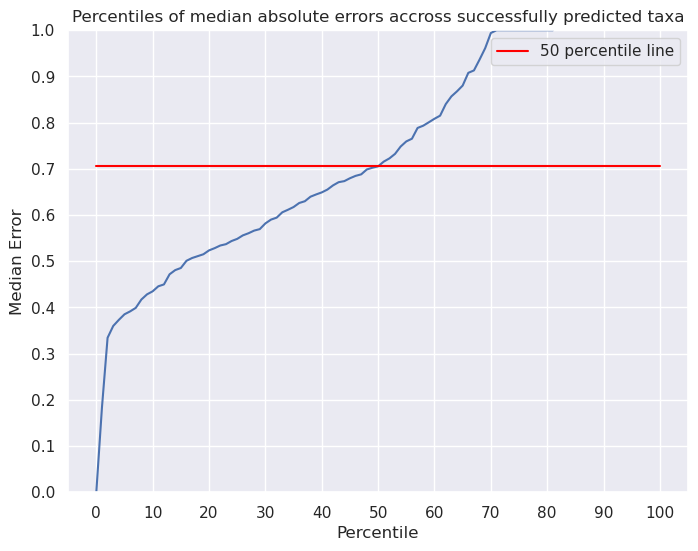

In [74]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)

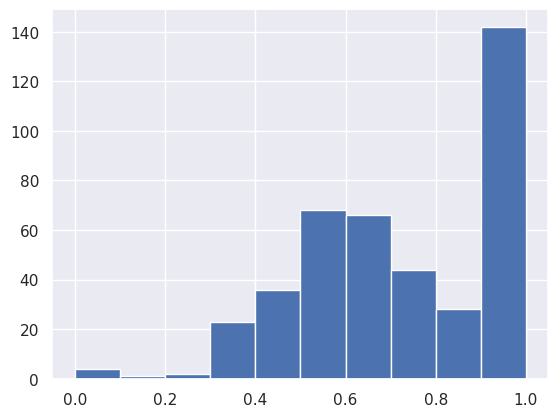

In [75]:
plt.hist(only_predicted_errors.median().clip(0, 1))
plt.show()

## Errors versus feature populations

In [76]:
population_rates = calculate_population_rates(df).drop(['subject_id', 'sampling_day'])

What are the average population rates in the taxa that are predicted by this model compared to the ones that arent?

In [77]:
population_rates[non_predicted_taxa].mean()

0.7014847557520119

In [78]:
population_rates[only_predicted_taxa].mean()

0.7200953152197181

Among the predicted taxa, is the median error somehow related to the population rate?

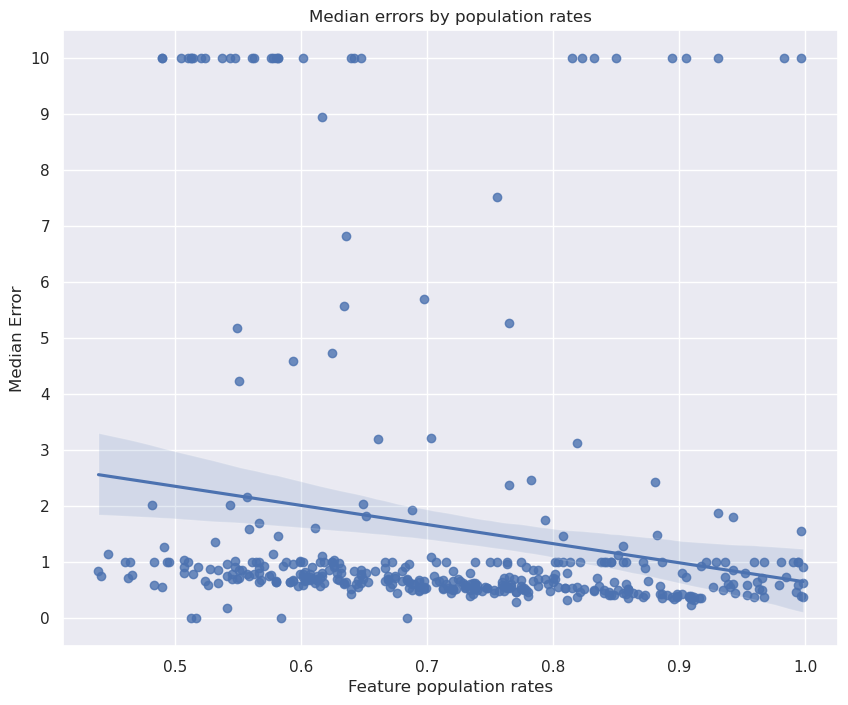

In [79]:
median_errors_by_population_rate(df, only_predicted_errors, only_predicted_taxa)

In [80]:
population_rates.describe()

count   500.000000
mean      0.717484
std       0.139092
min       0.439306
25%       0.603083
50%       0.708092
75%       0.823218
max       0.998073
dtype: float64